In [1]:
#!pip install scikit-learn --force
#!pip install catboost

In [2]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
from datetime import datetime
import os
import importlib

pd.set_option('display.max.columns', 300)

from core.calculator.storage import ModelDB
from core.calculator.core import ForecastConfig
from core.calculator.core import TrainingManager
from core.calculator.core import ForecastConfig
from core.calculator.core import ForecastEngine

from core.calculator.deposits import DepositsCalculationType
from core.calculator.deposits import DepositIterativeCalculator

from core.definitions import *
from core.project_update import load_portfolio

from core.models import DepositModels
from warnings import filterwarnings
filterwarnings('ignore')

## Парсим данные

__От Марка:__  
Я на прошлой неделе делал прогноз, вроде в целом норм, но все прошло не до конца гладко.  
Попробуй сегодня его сделать и подготовить все файлы, как если бы мы их отправляли в казну, а завтра сравним наши результаты и я расскажу с какими трудностями столкнулся и что можно улучшить, чтобы в следующий раз потратить меньше времени  


__От Каурова:__  

Во вложении сценарий среднемесячных ТС и КС в формате шаблонов CF-калькулятора. Они получены из среднеквартальных значений, присланных ранее Андреем Пардоновым.  

Пожалуйста, посчитайте прогноз объёмов для вкладов и счетов физлиц.  

P.S. В шаблонах много лишнего – бесполезного для вас, но нужного для CF-калькулятора:  
- в обоих файлах есть история;  
- в обоих файлах есть валюты;  
- в файле ТС (ftp.csv) помимо ТС есть спреды для сделок с плавающими ставками (cf_cd = FTP_KS и др); вам нужна только ТС (cf_cd = FTP)  
- в файле КС (indicators.csv) помимо КС есть другие индикаторы; вам нужна только КС.  
Если вам неудобно работать с такими файлами, пожалуйста, напишите об этом: мы обрежем лишнее на своей стороне.  


In [3]:
ftp_data = pd.read_csv('./data_csv/ftp_20230818.csv', delimiter=';')
ftp_data.head()

,start_dttm,end_dttm,cf_cd,currency_id,term,cf_value
0,2023-09-01,2023-09-30,FTP,RUB,1D,0.12
1,2023-09-01,2023-09-30,FTP,RUB,7D,0.12
2,2023-09-01,2023-09-30,FTP,RUB,14D,0.12
3,2023-09-01,2023-09-30,FTP,RUB,21D,0.12
4,2023-09-01,2023-09-30,FTP,RUB,1M,0.12


In [4]:
ftp_data = ftp_data[ftp_data['end_dttm']>='2023-07-31']
ftp_data = ftp_data[ftp_data['cf_cd']=='FTP']
ftp_data = ftp_data[ftp_data['currency_id']=='RUB']

In [5]:
term_list = ['3M', '6M', '1Y', '18M', '2Y', '3Y']

In [6]:
ftp_data = ftp_data[ftp_data.term.isin(term_list)]

In [7]:
ftp_data.head()

,start_dttm,end_dttm,cf_cd,currency_id,term,cf_value
6,2023-09-01,2023-09-30,FTP,RUB,3M,0.12
7,2023-09-01,2023-09-30,FTP,RUB,6M,0.12
10,2023-09-01,2023-09-30,FTP,RUB,1Y,0.12
11,2023-09-01,2023-09-30,FTP,RUB,18M,0.12
12,2023-09-01,2023-09-30,FTP,RUB,2Y,0.12


In [8]:
indicators_data = pd.read_csv('./data_csv/indicators_20230817.csv', delimiter=';')
indicators_data.head()

,start_dttm,end_dttm,cf_cd,cf_value
0,2023-07-01,2023-07-31,KEYRATECBRF,0.0776
1,2023-08-01,2023-08-31,KEYRATECBRF,0.1042
2,2023-09-01,2023-09-30,KEYRATECBRF,0.1200
3,2023-10-01,2023-10-31,KEYRATECBRF,0.1200
4,2023-11-01,2023-11-30,KEYRATECBRF,0.1200


In [9]:
indicators_data = indicators_data[indicators_data['end_dttm']>='2023-07-31']
indicators_data = indicators_data[indicators_data['cf_cd']=='KEYRATECBRF']

In [10]:
np.sort(ftp_data.end_dttm.unique())

array(['2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31',
       '2023-11-30', '2023-12-31'], dtype=object)

In [11]:
np.sort(ftp_data.end_dttm.unique()).shape

(6,)

In [12]:
(ftp_data[ftp_data['term']=='3M'].sort_values(by='end_dttm').cf_value*100).to_list()

[8.4629, 10.653225800000001, 12.0, 12.0, 12.0, 12.0]

In [13]:
term_list

['3M', '6M', '1Y', '18M', '2Y', '3Y']

Индикатор будем использовать как максимальную ставку сбера

In [14]:
(indicators_data.sort_values(by='end_dttm')['cf_value']+0.01).to_list()

[0.0876, 0.1142, 0.13, 0.13, 0.13, 0.13]

In [15]:
# Дата из который мы прогнозируем (пока что не меняется)
train_end = datetime(year=2023, month=6, day=30)

# Горизонт прогноза в месяцах
horizon = 6

In [16]:
# Данные для прогноза
scenario_data = {
    # Ожидаемый баланс на первую дату прогноза, задавать необязательно
     'expected_amount':      [np.nan for h in range(horizon)],
    # ССВ
     'SSV':                  [0.3 for h in range(horizon)],
    # ФОР
     'FOR':                  [0.2 for h in range(horizon)],
    # Трансфертные ставки
     'VTB_ftp_rate_[90d]':   (ftp_data[ftp_data['term']=='3M'].sort_values(by='end_dttm').cf_value*100).to_list(),
     'VTB_ftp_rate_[180d]':  (ftp_data[ftp_data['term']=='6M'].sort_values(by='end_dttm').cf_value*100).to_list(),
     'VTB_ftp_rate_[365d]':  (ftp_data[ftp_data['term']=='1Y'].sort_values(by='end_dttm').cf_value*100).to_list(),
     'VTB_ftp_rate_[548d]':  (ftp_data[ftp_data['term']=='18M'].sort_values(by='end_dttm').cf_value*100).to_list(),
     'VTB_ftp_rate_[730d]':  (ftp_data[ftp_data['term']=='2Y'].sort_values(by='end_dttm').cf_value*100).to_list(),
     'VTB_ftp_rate_[1095d]': (ftp_data[ftp_data['term']=='3Y'].sort_values(by='end_dttm').cf_value*100).to_list(),
    
    # Маржа бизнеса по срочностям
     'margin_[90d]':         [0.7 for h in range(horizon)],
     'margin_[180d]':        [0.7 for h in range(horizon)],
     'margin_[365d]':        [0.7 for h in range(horizon)],
     'margin_[548d]':        [0.7 for h in range(horizon)],
     'margin_[730d]':        [0.7 for h in range(horizon)],
     'margin_[1095d]':       [0.7 for h in range(horizon)],
    
    # Спред Привилегия - Массовый (на сколько в среднем ставки по сегменту Привилегия больше чем ставки по массовому сегменту)
     'priv_spread':          [0.5 for h in range(horizon)],
    # Спред ВИП - Массовый (на сколько в среднем ставки по сегменту ВИП больше чем ставки по массовому сегменту)
     'vip_spread':           [0.8 for h in range(horizon)],
    
    # Ниже три спреда по разным типам опциональности по отношению к безопциональным вкладам (Подразумевается, что они, как правило, отрицательные)
    # r - возможности пополнения, s - возможность расходных операций
    
    # На сколько ставка по расходным вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r0s1_spread':          [-0.2 for h in range(horizon)],
    
    # На сколько ставка по пополняемым вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r1s0_spread':          [-0.2 for h in range(horizon)],
    
    # На сколько ставка по расходно-пополняемым вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r1s1_spread':          [-0.2 for h in range(horizon)],
    
    # Ставка по лучшему предложению сбера
     'SBER_max_rate':        [7.5, 9.5, 11, 11, 11, 11],
    
    # Базовая ставка по НС
     'SA_rate':              [8 for h in range(horizon)]
}
scenario_df_user = pd.DataFrame(scenario_data)

In [17]:
scenario_df = preprocess_scenario(scenario_df_user, train_end, horizon)

In [18]:
scenario_df

,expected_amount,SBER_max_rate,rate_sa_weighted,VTB_ftp_rate_[90d],VTB_ftp_rate_[180d],VTB_ftp_rate_[365d],VTB_ftp_rate_[548d],VTB_ftp_rate_[730d],VTB_ftp_rate_[1095d],VTB_weighted_rate_[mass]_[r0s0]_[90d],VTB_weighted_rate_[mass]_[r0s0]_[180d],VTB_weighted_rate_[mass]_[r0s0]_[365d],VTB_weighted_rate_[mass]_[r0s0]_[548d],VTB_weighted_rate_[mass]_[r0s0]_[730d],VTB_weighted_rate_[mass]_[r0s0]_[1095d],VTB_weighted_rate_[mass]_[r0s1]_[90d],VTB_weighted_rate_[mass]_[r0s1]_[180d],VTB_weighted_rate_[mass]_[r0s1]_[365d],VTB_weighted_rate_[mass]_[r0s1]_[548d],VTB_weighted_rate_[mass]_[r0s1]_[730d],VTB_weighted_rate_[mass]_[r0s1]_[1095d],VTB_weighted_rate_[mass]_[r1s0]_[90d],VTB_weighted_rate_[mass]_[r1s0]_[180d],VTB_weighted_rate_[mass]_[r1s0]_[365d],VTB_weighted_rate_[mass]_[r1s0]_[548d],VTB_weighted_rate_[mass]_[r1s0]_[730d],VTB_weighted_rate_[mass]_[r1s0]_[1095d],VTB_weighted_rate_[mass]_[r1s1]_[90d],VTB_weighted_rate_[mass]_[r1s1]_[180d],VTB_weighted_rate_[mass]_[r1s1]_[365d],VTB_weighted_rate_[mass]_[r1s1]_[548d],VTB_weighted_rate_[mass]_[r1s1]_[730d],VTB_weighted_rate_[mass]_[r1s1]_[1095d],VTB_weighted_rate_[priv]_[r0s0]_[90d],VTB_weighted_rate_[priv]_[r0s0]_[180d],VTB_weighted_rate_[priv]_[r0s0]_[365d],VTB_weighted_rate_[priv]_[r0s0]_[548d],VTB_weighted_rate_[priv]_[r0s0]_[730d],VTB_weighted_rate_[priv]_[r0s0]_[1095d],VTB_weighted_rate_[priv]_[r0s1]_[90d],VTB_weighted_rate_[priv]_[r0s1]_[180d],VTB_weighted_rate_[priv]_[r0s1]_[365d],VTB_weighted_rate_[priv]_[r0s1]_[548d],VTB_weighted_rate_[priv]_[r0s1]_[730d],VTB_weighted_rate_[priv]_[r0s1]_[1095d],VTB_weighted_rate_[priv]_[r1s0]_[90d],VTB_weighted_rate_[priv]_[r1s0]_[180d],VTB_weighted_rate_[priv]_[r1s0]_[365d],VTB_weighted_rate_[priv]_[r1s0]_[548d],VTB_weighted_rate_[priv]_[r1s0]_[730d],VTB_weighted_rate_[priv]_[r1s0]_[1095d],VTB_weighted_rate_[priv]_[r1s1]_[90d],VTB_weighted_rate_[priv]_[r1s1]_[180d],VTB_weighted_rate_[priv]_[r1s1]_[365d],VTB_weighted_rate_[priv]_[r1s1]_[548d],VTB_weighted_rate_[priv]_[r1s1]_[730d],VTB_weighted_rate_[priv]_[r1s1]_[1095d],VTB_weighted_rate_[vip]_[r0s0]_[90d],VTB_weighted_rate_[vip]_[r0s0]_[180d],VTB_weighted_rate_[vip]_[r0s0]_[365d],VTB_weighted_rate_[vip]_[r0s0]_[548d],VTB_weighted_rate_[vip]_[r0s0]_[730d],VTB_weighted_rate_[vip]_[r0s0]_[1095d],VTB_weighted_rate_[vip]_[r0s1]_[90d],VTB_weighted_rate_[vip]_[r0s1]_[180d],VTB_weighted_rate_[vip]_[r0s1]_[365d],VTB_weighted_rate_[vip]_[r0s1]_[548d],VTB_weighted_rate_[vip]_[r0s1]_[730d],VTB_weighted_rate_[vip]_[r0s1]_[1095d],VTB_weighted_rate_[vip]_[r1s0]_[90d],VTB_weighted_rate_[vip]_[r1s0]_[180d],VTB_weighted_rate_[vip]_[r1s0]_[365d],VTB_weighted_rate_[vip]_[r1s0]_[548d],VTB_weighted_rate_[vip]_[r1s0]_[730d],VTB_weighted_rate_[vip]_[r1s0]_[1095d],VTB_weighted_rate_[vip]_[r1s1]_[90d],VTB_weighted_rate_[vip]_[r1s1]_[180d],VTB_weighted_rate_[vip]_[r1s1]_[365d],VTB_weighted_rate_[vip]_[r1s1]_[548d],VTB_weighted_rate_[vip]_[r1s1]_[730d],VTB_weighted_rate_[vip]_[r1s1]_[1095d]
2023-07-31,NaN,7.5,8.0,8.462900,8.633900,8.887100,9.098400,9.309700,9.677400,6.645974,6.816632,7.069326,7.280203,7.491081,7.858045,6.445974,6.616632,6.869326,7.080203,7.291081,7.658045,6.445974,6.616632,6.869326,7.080203,7.291081,7.658045,6.445974,6.616632,6.869326,7.080203,7.291081,7.658045,7.145974,7.316632,7.569326,7.780203,7.991081,8.358045,6.945974,7.116632,7.369326,7.580203,7.791081,8.158045,6.945974,7.116632,7.369326,7.580203,7.791081,8.158045,6.945974,7.116632,7.369326,7.580203,7.791081,8.158045,7.445974,7.616632,7.869326,8.080203,8.291081,8.658045,7.245974,7.416632,7.669326,7.880203,8.091081,8.458045,7.245974,7.416632,7.669326,7.880203,8.091081,8.458045,7.245974,7.416632,7.669326,7.880203,8.091081,8.458045
2023-08-31,NaN,9.5,8.0,10.653226,10.712903,10.870968,10.893548,10.916129,11.096774,8.831919,8.891477,9.049226,9.071761,9.094297,9.274581,8.631919,8.691477,8.849226,8.871761,8.894297,9.074581,8.631919,8.691477,8.849226,8.871761,8.894297,9.074581,8.631919,8.691477,8.849226,8.871761,8.894297,9.074581,9.331919,9.391477,9.5492

In [19]:
(ftp_data[ftp_data['term']=='1Y'].sort_values(by='end_dttm').cf_value*100).to_list()

[8.8871, 10.870967700000001, 12.0, 12.0, 12.0, 12.0]

In [20]:
scenario_df['VTB_weighted_rate_[mass]_[r0s0]_[365d]']

2023-07-31     7.069326
2023-08-31     9.049226
2023-09-30    10.176000
2023-10-31    10.176000
2023-11-30    10.176000
2023-12-31    10.176000
Freq: M, Name: VTB_weighted_rate_[mass]_[r0s0]_[365d], dtype: float64

In [21]:
port_folder = '../data/portfolio_data'
portfolio = load_portfolio(train_end, port_folder)

In [22]:
# если хотим обучить модели

from core.models.utils import run_spark_session
#spark = run_spark_session('check_calc')

spark = None #если без обучения

In [23]:
folder = '../data/trained_models'

sqlite_filepath = os.path.join(folder, 'modeldb_test.bin')

DB_URL = f"sqlite:///{sqlite_filepath}"
model_db = ModelDB(DB_URL)


In [24]:
dir(model_db)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_db_engine',
 '_db_session',
 '_db_url',
 '_delete_entity',
 '_save_trained_models',
 '_session_maker',
 'delete_backtest_by_tag',
 'delete_model',
 'delete_trained_models',
 'find_backtest',
 'find_ground_truth',
 'find_model',
 'find_models',
 'find_portfolio',
 'find_prediction_data',
 'find_trained_model',
 'find_trained_model_by_dt',
 'save_backtest',
 'save_model_info',
 'save_portfolio',
 'save_trained_model',
 'save_trained_models',
 'update_trained_model']

In [25]:
model_db.find_trained_model('sa_general_avg_balance_mass_201801_202307')

In [26]:
model_db.delete_trained_models('sa_general_avg_balance_mass_201801_202307')
model_db.delete_trained_models('sa_general_avg_balance_vip_201801_202307')
model_db.delete_trained_models('sa_general_avg_balance_priv_201801_202307')

False

In [27]:
dir(DepositsCalculationType)

['CurrentAccounts',
 'Deposits',
 'SavingAccounts',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [28]:
ENV_NAME = 'hmelevskoi_env'

os.environ['CC'] = 'x86_64-conda-linux-gnu-gcc'
os.environ['CXX'] = 'x86_64-conda-linux-gnu-g++'
os.environ['PATH'] = os.path.abspath(f'/tmp/envs/{ENV_NAME}/bin') + ':' + os.environ['PATH']

In [29]:
config: ForecastConfig = ForecastConfig(
    first_train_end_dt = train_end,
    horizon = horizon,
    trainers = DepositModels.trainers,
    data_loaders = DepositModels.dataloaders,
    calculator_type = DepositIterativeCalculator,
    calc_type = DepositsCalculationType,
    adapter_types = DepositModels.adapter_types,
    scenario_data = scenario_df,
    portfolio = portfolio
)
    
training_manager = TrainingManager(spark, config.trainers, folder, model_db)   
engine: ForecastEngine = ForecastEngine(spark, config, training_manager, overwrite_models=False)

In [30]:
%%time
engine.run_all()

INFO:core:missing models: []
INFO:core:add_models_from_bytes
INFO:core:plan_close_201402_202306 - adapter <class 'core.models.plan_close.plan_close_model.PlanCloseModelAdapter'>
INFO:core:renewal_model_201401_202306 - adapter <class 'core.models.renewal.renewal_model.RenewalModelAdapter'>
INFO:core:maturity_structure_mass_r0s0_201401_202306 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S0ModelAdapter'>
INFO:core:maturity_structure_mass_r0s1_202001_202306 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S1ModelAdapter'>
INFO:core:maturity_structure_mass_r1s0_201401_202306 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR1S0ModelAdapter'>
INFO:core:maturity_structure_mass_r1s1_201401_202306 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStruct

CPU times: user 41.9 s, sys: 2.33 s, total: 44.2 s
Wall time: 36.1 s


In [31]:
# вывод
portfolio_res = engine.calc_results['Deposits']['portfolio'] 
agg_res = engine.calc_results['Deposits']['agg_data']
maturity = engine.calc_results['Deposits']['maturity']
SavingAccounts = engine.calc_results['SavingAccounts']
CurrentAccounts = engine.calc_results['CurrentAccounts']
volumes = engine.calc_results['Volumes']

#### Сохранение прогнозов

In [32]:
#volumes.to_excel('./forecats/volumes_sa.xlsx')

In [33]:
#maturity.to_excel('./forecats/maturity.xlsx')

In [34]:
#agg_res.to_excel('./forecats/agg_res.xlsx')

In [35]:
SavingAccounts.groupby('report_dt').sum()

balance,general,kopilka,safe
report_dt,,,
2023-07-31,1.193097e+12,1.849392e+11,1.008158e+12
2023-08-31,1.200821e+12,1.849392e+11,1.015881e+12
2023-09-30,1.199473e+12,1.849392e+11,1.014534e+12
2023-10-31,1.192192e+12,1.849392e+11,1.007253e+12
2023-11-30,1.191827e+12,1.849392e+11,1.006888e+12
2023-12-31,1.194110e+12,1.849392e+11,1.009171e+12


In [36]:
mass = agg_res[agg_res['segment']=='mass']
priv = agg_res[agg_res['segment']=='priv']
vip = agg_res[agg_res['segment']=='vip']

In [37]:
agg_res.groupby('report_dt').sum()

,replenishable_flg,subtraction_flg,month_maturity,target_maturity_days,balance_start,balance_gain,balance,newbusiness,contract_close,early_withdrawal,operations,interests,renewal,universal_weight_id
report_dt,,,,,,,,,,,,,,
2023-07-31,30,27,1056,32103,3.148000e+12,-9.313413e+10,3.054866e+12,2.248149e+11,-2.444666e+11,-1.324940e+10,-7.686414e+10,1.663110e+10,4.819735e+10,299
2023-08-31,32,27,1065,32373,3.054866e+12,6.466604e+10,3.119532e+12,5.316906e+11,-2.442968e+11,-2.793177e+10,-2.100033e+11,1.520725e+10,6.847610e+10,304
2023-09-30,32,27,1065,32373,3.119532e+12,7.484665e+10,3.194378e+12,7.764759e+11,-4.115011e+11,-6.255656e+10,-2.427669e+11,1.519528e+10,9.739678e+10,304
2023-10-31,34,26,1062,32278,3.194378e+12,8.144450e+10,3.275823e+12,5.357827e+11,-2.598700e+11,-5.149543e+10,-1.626857e+11,1.971288e+10,4.204963e+10,304
2023-11-30,33,25,1038,31548,3.275823e+12,5.775861e+10,3.333582e+12,4.630267e+11,-2.943231e+11,-2.818179e+10,-1.044153e+11,2.165210e+10,6.564173e+10,294
2023-12-31,33,25,1038,31548,3.333582e+12,1.446453e+11,3.478227e+12,5.020112e+11,-2.816209e+11,-2.115020e+10,-7.768469e+10,2.308982e+10,8.666512e+10,294


In [38]:
agg_res.groupby('report_dt').sum()['balance']

report_dt
2023-07-31    3.054866e+12
2023-08-31    3.119532e+12
2023-09-30    3.194378e+12
2023-10-31    3.275823e+12
2023-11-30    3.333582e+12
2023-12-31    3.478227e+12
Name: balance, dtype: float64

In [39]:
agg_res.groupby('report_dt').sum()['balance'] + agg_res.groupby('report_dt').sum()['early_withdrawal']

report_dt
2023-07-31    3.041616e+12
2023-08-31    3.091600e+12
2023-09-30    3.131822e+12
2023-10-31    3.224327e+12
2023-11-30    3.305400e+12
2023-12-31    3.457077e+12
dtype: float64

In [40]:
agg_res.groupby('report_dt').sum()['newbusiness'] + agg_res.groupby('report_dt').sum()['early_withdrawal']

report_dt
2023-07-31    2.115655e+11
2023-08-31    5.037588e+11
2023-09-30    7.139193e+11
2023-10-31    4.842873e+11
2023-11-30    4.348449e+11
2023-12-31    4.808610e+11
dtype: float64

In [41]:
import matplotlib.pyplot as plt

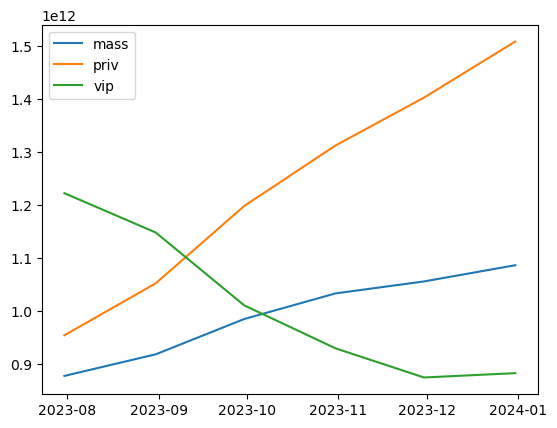

In [42]:
plt.plot(mass.groupby('report_dt').sum()['balance'], label='mass')
plt.plot(priv.groupby('report_dt').sum()['balance'], label='priv')
plt.plot(vip.groupby('report_dt').sum()['balance'], label='vip')
plt.legend()

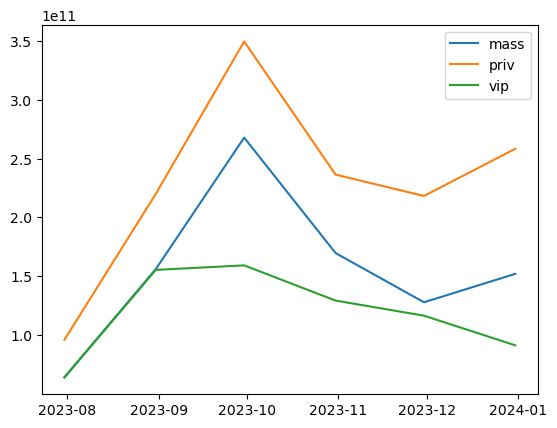

In [43]:
plt.plot(mass.groupby('report_dt').sum()['newbusiness'], label='mass')
plt.plot(priv.groupby('report_dt').sum()['newbusiness'], label='priv')
plt.plot(vip.groupby('report_dt').sum()['newbusiness'], label='vip')
plt.legend()